# Visualize results from MIGHT estimation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sktree.datasets import make_trunk_classification
from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _non_nan_samples,
)

seed = 12345
rng = np.random.default_rng(seed)

In [3]:
root_dir = Path("/Volumes/Extreme Pro/cancer")

SIMULATIONS_NAMES = {
    "1": "trunk",
    "2": "trunk-overlap",
}
n_dims_list = [2**i for i in range(12)]
n_dims_list[0] = 1
n_dims = 2048
n_samples = 524
use_second_split_for_threshold = False
model_names = ["might-threshold-third-split", "might-threshold-second-split"]

n_repeats = 5
n_samples_list = [2**x for x in range(8, 13)]
n_samples_ = 4096
n_dims_ = 4096

print(n_samples_list)
print(n_dims_list)
print(n_samples_)

[256, 512, 1024, 2048, 4096]
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
4096


In [8]:
results = defaultdict(list)

for model_name in model_names:
    for sim_name in SIMULATIONS_NAMES.values():
        for n_samples in n_samples_list:
            for idx in range(n_repeats):
                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )
                print(output_fname)
                print(output_fname.exists())

                # print(output_fname.exists())
                # Load data from the compressed npz file
                loaded_data = np.load(output_fname)

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims = loaded_data["n_dims"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims"].append(n_dims)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_256_2048_0.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_256_2048_1.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_256_2048_2.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_256_2048_3.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_256_2048_4.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_512_2048_0.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_512_2048_1.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_512_2048_2.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_512_2048_3.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold-third-split/trunk/trunk_512_2048_4.npz
True
/Volumes/Extreme Pro/cancer/output/might-threshold

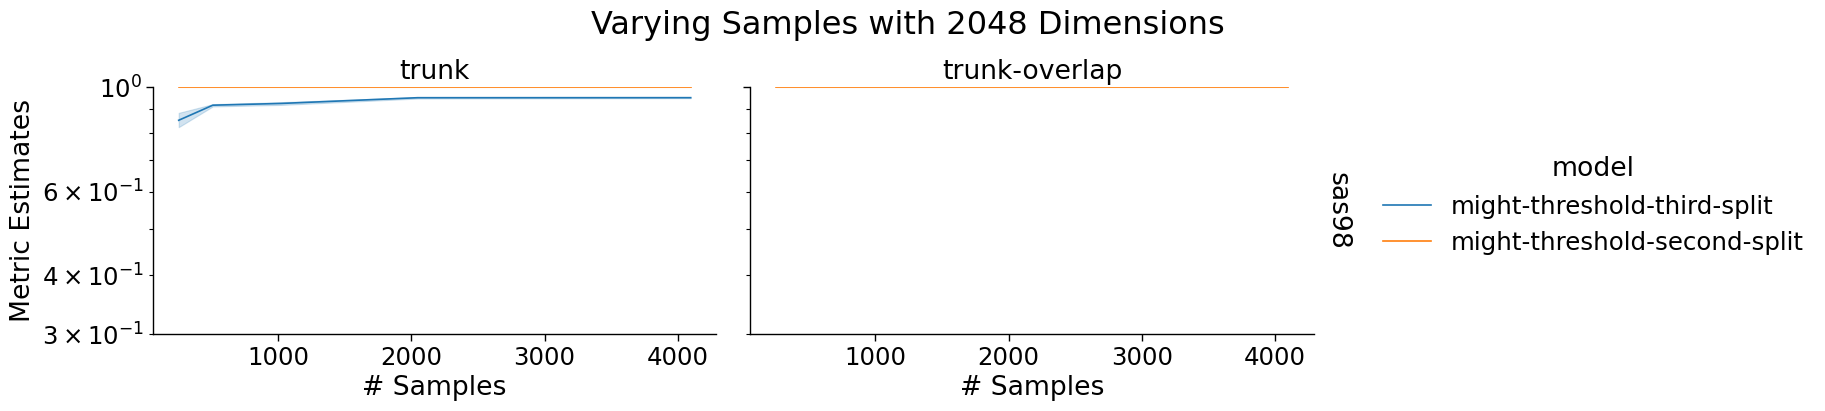

In [11]:
df = pd.DataFrame(results)
# df = df[
#     df["sim_type"]
#     .astype(str)
# ]

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_samples", "sim_type", "model"],
    value_vars=["sas98"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
# df_melted["n_dims"] = df_melted["n_dims"].astype(int)
df_melted["n_samples"] = df_melted["n_samples"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=4.0,
    aspect=1.75,
)
g.map(sns.lineplot, "n_samples", "metric_value")

# iterate through the axes
# for irow in range(3):
# g.axes[1][1].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[1][3].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")

g.axes[0][1].set(yscale="log", ylim=[0.3, 1])
# g.axes[1][].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Samples", "Metric Estimates")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Varying Samples with 2048 Dimensions", y=1.05)
plt.show()